# Image Approximation using Neural Networks

## Approximating 2D Images

In traditional function approximation (like we've done in the Function Approximation notebook), the network learns a mapping between inputs and outputs:

$$\large
x \rightarrow f(x)
$$

For images, we can generalize this to two dimensions:

$$\large
f(x, y)=\text{pixel intensity at coordinate} \ (x, y)
$$

Think of a grayscale image simply as a **continuous function over 2D space**, sampled at discrete points (pixels).

Like we've seen, neural networks are **[universal function approximators](https://en.wikipedia.org/wiki/Universal_approximation_theorem)**. If given enough capacity (layers/width) and data (pixel coordinates and values), they can learn an implicit mapping from 2D coordinates to pixel values, which means they can **learn to "paint" an image just from its coordinates**.

Implementation wise, the main idea is that each training example is a 2D input coordinate, and the output is a 1D grayscale target. 
First, we flatten the target image into a vector. 
For example, an image with $28\times28$ pixels is a $784\times1$ flattened column vector. 
We generate training examples, where each example is a 2D input coordinate.
In this case, it will be a $784\times2$ matrix, representing (x, y) coordinates.
The model learns a **smooth approximation** for mapping the 2D input coordinates into the 1D target pixel value (scalar).

## 1. Using an image from the MNIST dataset

Let's try to approximate an image from the MNIST dataset.

**Loading the data:**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# define a transform to convert images to tensors
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

# get paths and create data directory
path = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_dir = os.path.join(path, "data")
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# load MNIST test set
mnist = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)

# get a single image and its label
image_tensor, label = mnist[0]
print(f"Image shape: {image_tensor.shape}")  # [1, 28, 28]
print(f"Label: {label}")

Image shape: torch.Size([1, 28, 28])
Label: 7


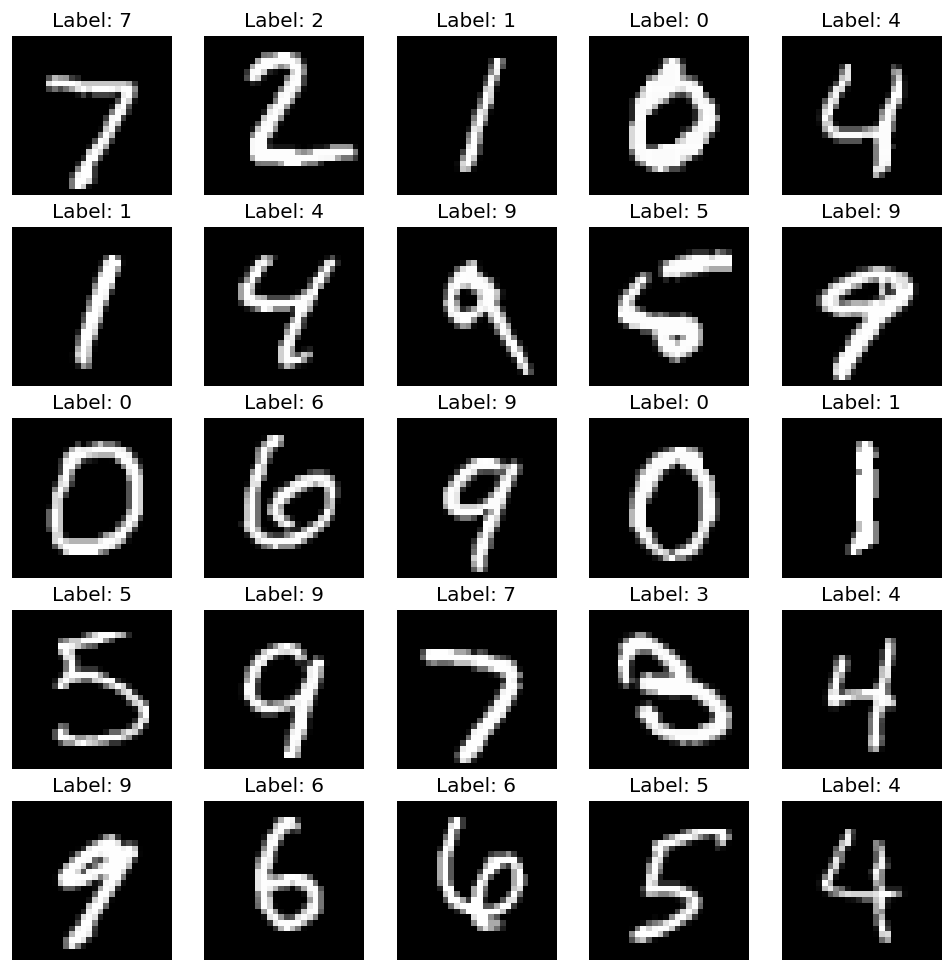

In [3]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10), dpi=120)
for i in range(25):
    image_tensor, label = mnist[i]
    row, col = i // 5, i % 5  # 5x5 grid
    ax[row, col].imshow(image_tensor.squeeze(), cmap="gray")
    ax[row, col].set_title(f"Label: {label}")
    ax[row, col].axis("off")
plt.show()

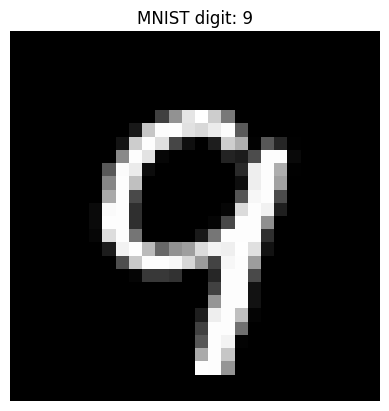

In [4]:
image_tensor, label = mnist[16]  # digit 9
plt.imshow(image_tensor.squeeze(), cmap="gray")
plt.title(f"MNIST digit: {label}")
plt.axis("off")
plt.show()

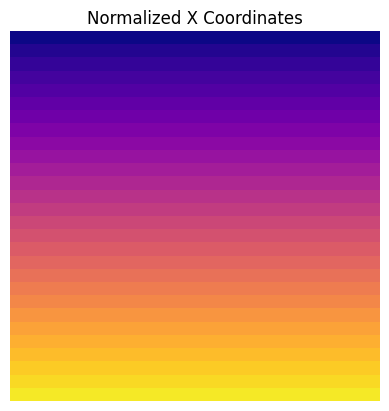

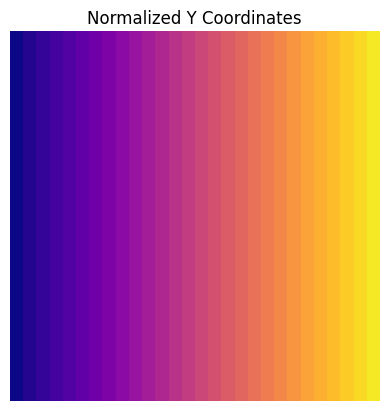

In [5]:
# remove the channel dimension
target_image = image_tensor.squeeze(0)
height, width = target_image.shape

# create a grid of points
coords = (
    torch.stack(
        torch.meshgrid(torch.arange(height), torch.arange(width), indexing="ij"), dim=-1
    )
    .reshape(-1, 2)
    .float()
)

# Normalize coords to [0, 1]
coords[:, 0] /= height
coords[:, 1] /= width

# flatten images to column vectors for training
x = coords  # shape: [784, 2]
y = target_image.reshape(-1, 1)  # shape: [784, 1]

# visualize
plt.imshow(coords[:, 0].reshape(height, width), cmap="plasma", vmin=0, vmax=1)
plt.title("Normalized X Coordinates")
plt.axis("off")
plt.show()

# visualize
plt.imshow(coords[:, 1].reshape(height, width), cmap="plasma", vmin=0, vmax=1)
plt.title("Normalized Y Coordinates")
plt.axis("off")
plt.show()

In [6]:
import torch.nn as nn


class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.model(x)

In [7]:
# model training function
def train_model(
    x,
    y,
    model,
    criterion,
    optimizer,
    epochs,
    epoch_print_freq: int = 10,
):
    losses = []
    preds = [torch.zeros_like(y).numpy()]
    for epoch in range(epochs + 1):
        outputs = model(x)
        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss)
        preds.append(model(x).detach().numpy())
        if epoch % epoch_print_freq == 0:
            print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}")
    return losses, preds

In [8]:
model = NeuralNetwork(input_dim=2, hidden_dim=128, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 5000


# train the model
losses, preds = train_model(
    x, y, model, criterion, optimizer, epochs, epoch_print_freq=500
)

# model predictions
with torch.no_grad():
    model_pred = model(x).numpy()

Epoch [0/5000], Loss: 0.0844
Epoch [500/5000], Loss: 0.0655
Epoch [1000/5000], Loss: 0.0604
Epoch [1500/5000], Loss: 0.0474
Epoch [2000/5000], Loss: 0.0335
Epoch [2500/5000], Loss: 0.0235
Epoch [3000/5000], Loss: 0.0149
Epoch [3500/5000], Loss: 0.0112
Epoch [4000/5000], Loss: 0.0075
Epoch [4500/5000], Loss: 0.0072
Epoch [5000/5000], Loss: 0.0048


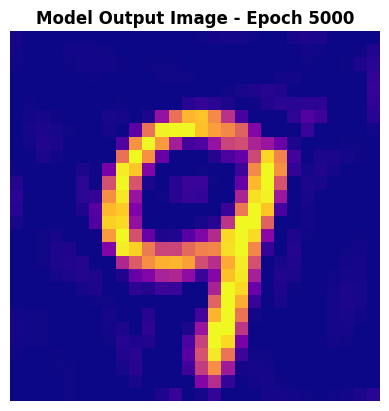

In [9]:
import numpy as np

image_out = model_pred.reshape(height, width)
plt.imshow(np.clip(image_out, 0, 1), cmap="plasma")
plt.title(f"Model Output Image - Epoch {epochs}", weight="bold")
plt.axis("off")
plt.show()

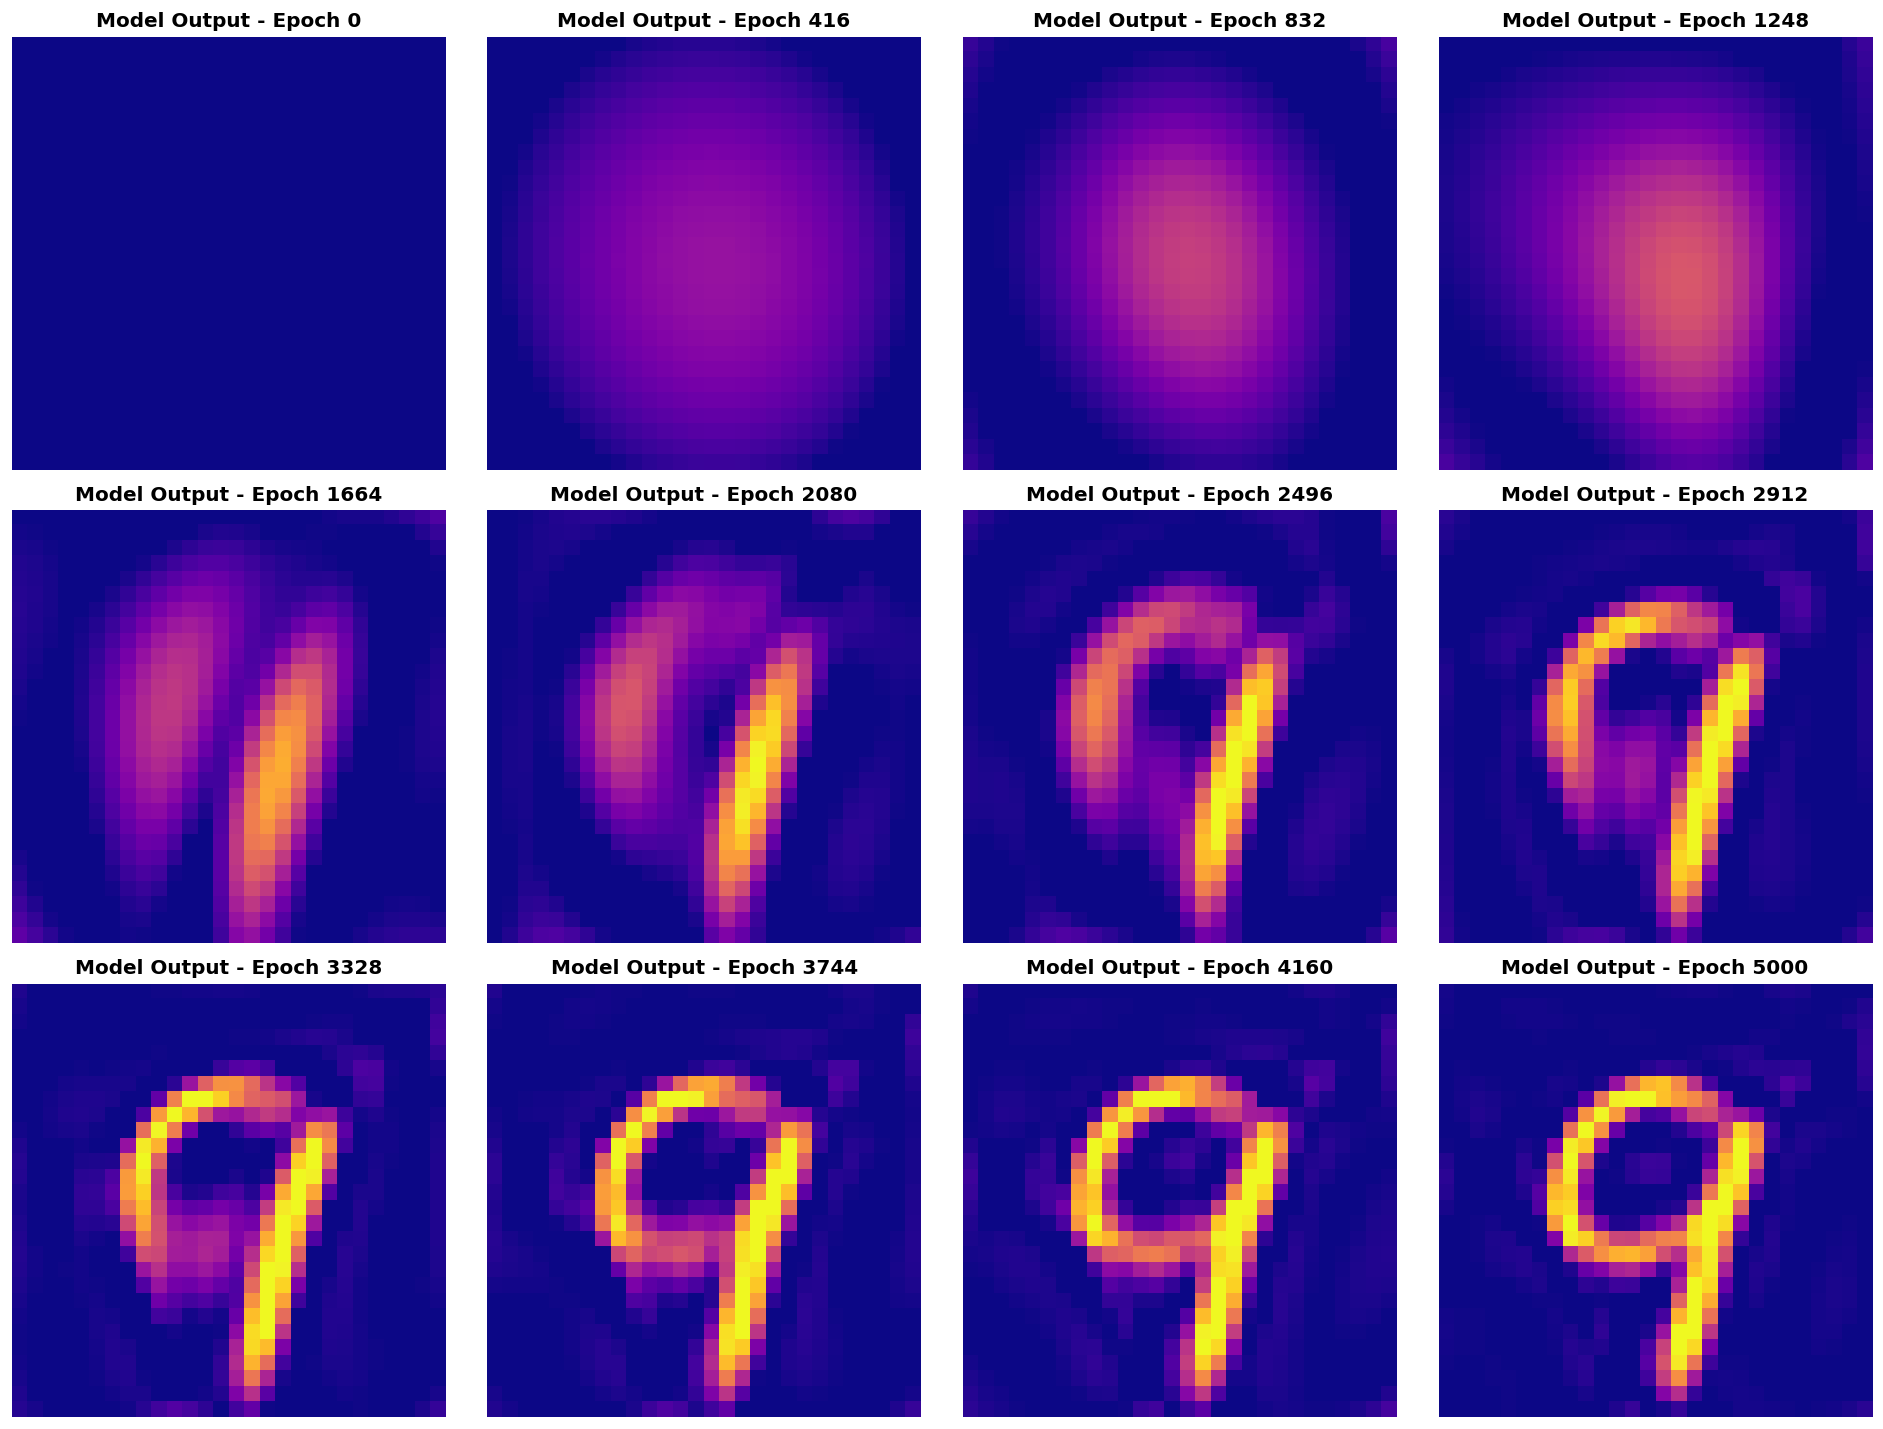

In [10]:
from implicitnet.plotting import plot_image_predictions

plot_image_predictions(
    predictions=preds,
    height=28,
    width=28,
    rows_cols=(3, 4),  # or (2, 4) if you want more
    cmap="plasma",
    title_prefix="Model Output",
)